# Blind Detection
## Sckitlearn classification
New model created using evenly distributed categories.

Note: Apply grid search and cross validation after getting it to work.

### On the  data set 

The dataset provides a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy(DRP) on a scale of 0 to 4:

0.  No DR
1.  Mild
2.  Moderate
3.  Severe
4.  Proliferative DR

In [20]:
# File moving imports
import os
import shutil

# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import datasets, classifiers and performance metrics
import skimage.io as io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn import svm, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

#save model
from joblib import dump, load


## Sorting all images by category into folders 
Sort all images into diffrent folders based on category to remove bias in the data.

All images from the "DrpTest" folder are copied over and sorted into 5 diffrent folders inside the "Sorted" folder.

In [21]:
srcpath = "Data/DrpTest/"
newPath = 'Data/Sorted/'
limit = 200

labels = pd.read_csv("Data/trainLabels.csv")
labels = labels.set_index('image')
# Delete old files from the sorted folder
oldFiles = os.listdir(newPath)
for file in oldFiles:
    os.remove(newPath + file)

#create a category img limit
limitTracker = [-abs(limit*3),0,0,0,0]
# create destination directories and store their names along with full paths
for filename in labels.index:
    filename = filename + '.png'
    fileCategory = labels.loc[(filename)[0:-4], 'level']
    if limitTracker[fileCategory] < limit:
        limitTracker[fileCategory]+=1
        oldFolder = srcpath + filename
        newFolder = newPath + str(labels.loc[(filename)[0:-4], 'level']) + '_' + filename
        shutil.copy(oldFolder, newFolder)
# note: might give keyerror if it reaches the labels.csv file

## Labels
Load the labels containing the DRP category of the images used while training the model.

In [22]:
labels = pd.read_csv("C:/Users/mauri/Documents/GitHub/EyeDiseaseDetection/Data/trainLabels.csv")

In [23]:
labelsIndexed = labels.set_index('image')
labelsIndexed.sample(10)

,level
image,
27004_left,2
26496_left,0
36815_left,0
36663_right,0
39676_right,0
32465_left,0
17945_left,0
34334_left,2
25331_right,0


### Sorting labels
Create diffrent label dataframes for each DRP category and link them back together to sort them.

This makes it so that the labels lign up with the new data folders createded.

In [24]:
# Sort labels by category, then take the first x images
imagesPerCategory = limit

SortedLabels = (labelsIndexed.loc[labelsIndexed['level']==0])[0:imagesPerCategory*4]
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==1])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==2])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==3])[0:imagesPerCategory])
SortedLabels = SortedLabels.append((labelsIndexed.loc[labelsIndexed['level']==4])[0:imagesPerCategory])
SortedLabels.head(limit+3)

,level
image,
10_left,0
10_right,0
13_left,0
13_right,0
17_left,0
...,...
301_left,0
307_left,0
307_right,0


In [25]:
# Turn the pandas dataframe into a numpy array that can be read by the model
label_list =(SortedLabels[['level']].values.flatten().tolist())
label_list = np.asarray(label_list)
# Convert the categories into a binary solutio
convertedLabelList = np.where(label_list > 1, 1, label_list)
convertedLabelList

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
# Used in the evaluation section, translates the category number into readable text
label_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
label_names[label_list[1]]

'No DR'

## Model
### Loading the images
First, load the images using a load function that resizes all images to the same resolution and greyscale them to remove a third demension from the array.

In [27]:
standerdImgHeight = 597
standerdImgWidth = 896

def transformImage(f, img_num=None):
        img = io.imread(f)
        im_res = resize(img,(standerdImgHeight, standerdImgWidth))
        return im_res

def transformImageFlat(f, img_num=None):
        img = io.imread(f)
        # im_res = resize(img,(597, 896))
        ## Turn images grey
        img_gray = rgb2gray(img)        
        im_res = resize(img_gray,(standerdImgHeight, standerdImgWidth))
        # Reshape 2d array into 1d array
        im_res = np.reshape(im_res, (standerdImgHeight*standerdImgWidth))

        return im_res

In [28]:
if __name__ == "__main__":
    img_collections = io.ImageCollection('Data/testSet/*.png',load_func=transformImage)
    img_collectionsFlat = io.ImageCollection('Data/Sorted/*.png',load_func=transformImageFlat)

In [29]:
# Difrent shape of the 2 imgCollections
i = 0
print(img_collections[i].shape)
print(img_collectionsFlat[i].shape)

(597, 896, 3)
(534912,)


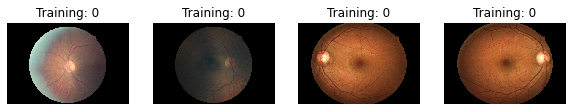

In [30]:
# Code for drawing example images (colored version used since 1d array is not recognized)
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, img_collections, label_list):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

### Creating the model

In [31]:
# flatten the images
n_samples = len(img_collectionsFlat)
data = img_collectionsFlat
label_list = convertedLabelList

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)
# clf = svm.LinearSVC()
# clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, label_list, test_size=0.3, shuffle=True
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

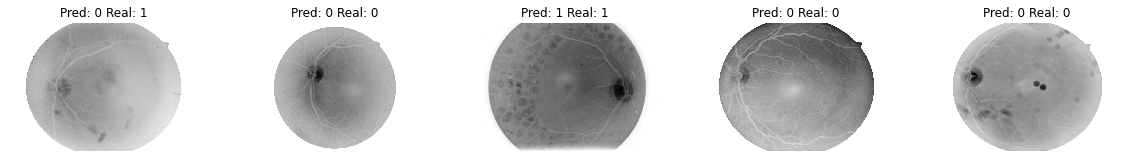

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for ax, image, prediction, realCat in zip(axes, X_test, predicted, y_test):
    ax.set_axis_off()
    image = image.reshape(597, 896)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Pred: {prediction} Real: {realCat}")

### Evaluation

In [ ]:
print(
    f"CLassification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

CLassification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       124
           1       0.50      0.52      0.51       116

    accuracy                           0.52       240
   macro avg       0.52      0.52      0.52       240
weighted avg       0.52      0.52      0.52       240




In [ ]:
# Save the model to a file for later evaluation/testing
dump(clf, 'Models/ModelSortedBinary100.joblib') 

FileNotFoundError: [Errno 2] No such file or directory: 'Models/ModelSortedBinary100.joblib'